In [162]:
#paquet pour la modelisation et la resolution du programme linéaire
#from mip import *
#paquet pour utiliser des structures de données plus efficaces
from matplotlib.pyplot import *
import itertools as it
import numpy as np
import random as rand
from mip import *

# Programme principal

In [163]:
class Data() :
    
    def __init__(self,data_legume,data_terrain):
        #fill legum data first
        with open(data_legume,'r') as file:
            line = file.readline()  # lit la 1ère ligne
            lineTab = line.split()
            #print(lineTab)
            self.horizon = int(lineTab[0])
            self.an = 24
            self.nblegumes = int(lineTab[1])
            self.lnumber = np.empty(self.nblegumes+2)
            self.name = []
            self.family = np.empty(self.nblegumes+2)
            self.croissance = np.empty(self.nblegumes+2,dtype = int)
            self.rest = np.empty(self.nblegumes+2,dtype = int)
            self.price = []
            for i in range(self.nblegumes):
                line = file.readline()
                lineTab = line.split()
                self.lnumber[i]=int(lineTab[0])
                #print(lineTab[1])
                self.name.append(lineTab[1])
                #print(self.name[i])
                self.family[i]=int(lineTab[2])
                self.croissance[i]=int(lineTab[3])
                self.rest[i]=int(lineTab[4])
                priceofi = []
                for j in range (self.horizon):
                    priceofi.append(float(lineTab[j+5]))
                self.price.append(priceofi)
            #ajout fertilisation 
            line = file.readline()
            lineTab=line.split()
            self.lnumber[self.nblegumes]=int(lineTab[0])
            self.name.append(lineTab[1])
            self.family[self.nblegumes]=int(lineTab[2])
            self.croissance[self.nblegumes]=int(lineTab[3])
            self.rest[self.nblegumes]=0
            self.price.append(np.zeros(self.horizon))
            #ajout jachere
            line = file.readline()
            lineTab=line.split()
            self.lnumber[self.nblegumes+1]=int(lineTab[0])
            self.name.append(lineTab[1])
            self.family[self.nblegumes+1]=int(lineTab[2])
            self.croissance[self.nblegumes+1]=int(lineTab[3])
            self.rest[self.nblegumes+1]=0
            self.price.append(np.zeros(self.horizon))
            
        #fill parcell data
        with open(data_terrain,'r') as file:
            line = file.readline()
            lineTab = line.split()
            self.nbparcelle = int(lineTab[0])
            self.pnumber=np.empty(self.nbparcelle)
            self.surface=np.empty(self.nbparcelle)
            self.nbvoisin=np.empty(self.nbparcelle,dtype = int)
            self.voisin=[]
            for i in range(self.nbparcelle):
                line = file.readline()
                lineTab = line.split()
                self.pnumber[i]=int(lineTab[0])
                self.surface[i]=float(lineTab[1])
                self.nbvoisin[i]=int(lineTab[2])
                voisin_i=[]
                for j in range(self.nbvoisin[i]):
                    voisin_i.append(int(lineTab[3+j]))
                self.voisin.append(voisin_i)
                
    def resume(self):
        print("Resume du jeu de donnée :")
        print("Notre horizon de temps est constitué de ",self.horizon," périodes.")
        print("Le terrain est composée de ",self.nbparcelle," :")
        for i in range (self.nbparcelle):
            print("  -La parcelle ",self.pnumber[i]," a une surface de ",self.surface[i],"m2 et a ",self.nbvoisin[i]," voisins : ",self.voisin[i])
        print("Nous avons ",self.nblegumes," disponibles :")
        for i in range(self.nblegumes+2):
            print("  -Le légume ",self.lnumber[i]," ",self.name[i]," est de la famille ",self.family[i], " son temps de croissance est de ",self.croissance[i]," périodes.")
            print("la terre doit se reposer ",self.rest[i]," suite a sa culture")
    def legumeInfo(self,x):
        print( self.name[x]," suit le calendrier suivant :")
        print(self.price[x])


#start model test
def build_model(Data):
    model = Model(name = "solver", solver_name=CBC)
    #creating variables
    z=[[[model.add_var(name='z'+str(p)+'_'+str(l)+'_'+str(t),var_type=BINARY) for t in range (Data.horizon) ]for l in range (Data.nblegumes+2)]for p in range (Data.nbparcelle)]
    x=[[[model.add_var(name='x'+str(p)+'_'+str(l)+'_'+str(t),var_type=BINARY) for t in range (Data.horizon) ]for l in range (Data.nblegumes+2)]for p in range (Data.nbparcelle)]
    z = np.array(z)
    x = np.array(x)
    #objective
    model.objective = maximize(xsum(z[p][l][t]*Data.surface[p]*Data.price[l][t] for p in range(Data.nbparcelle) for l in range(Data.nblegumes+2) for t in range(Data.horizon) if abs(Data.price[l][t])>1e-6 ) ) #
    #constraint
    #fertilisation
    for p in range(Data.nbparcelle):
        model.add_constr(xsum(z[p][Data.nblegumes][t] for t in range (Data.horizon)) >=1)
    #jachere
    for p in range(Data.nbparcelle):
        model.add_constr(xsum(z[p][Data.nblegumes+1][t] for t in range (Data.horizon)) >=1)
    #une parcelle ne peut pas etre occupé par plus d'un legume
    for p in range(Data.nbparcelle):
        for t in range(Data.horizon):
            model.add_constr(xsum(x[p][l][t] for l in range(Data.nblegumes+2)) <= 1)
    #adjacence
    for p in range(Data.nbparcelle):
        for pprim in Data.voisin[p]:
            for l in range(Data.nblegumes+2):
                for t in range(Data.horizon):
                    model.add_constr(xsum(x[pprim][lprim][t] for lprim in range(Data.nblegumes+2) if Data.family[lprim]==Data.family[l] and Data.lnumber[lprim] != Data.lnumber[l])  <= 1-x[p][l][t] )
    #continuite
    for p in range(Data.nbparcelle):
        for l in range(Data.nblegumes+2):
            for t in range(Data.horizon):
                model.add_constr(xsum(z[p][lprim][tprim] for lprim in range(Data.nblegumes+2) for tprim in range( (t-Data.croissance[lprim]-Data.rest[lprim]+1)%Data.horizon ,t) if Data.family[lprim]==Data.family[l] ) <= 1-z[p][l][t] )
                model.add_constr(xsum(z[p][l][tprim] for tprim in range(t-Data.croissance[l]+1,t+1))  == x[p][l][t] )                         
    return model



def model_solution(Data):
    model  = build_model(Data)
    status = model.optimize(max_seconds=300)
    if status == OptimizationStatus.OPTIMAL:
        print('optimal solution cost {} found'.format(model.objective_value))
    elif status == OptimizationStatus.FEASIBLE:
        print('sol.cost {} found, best possible: {}'.format(model.objective_value, model.objective_bound))
    elif status == OptimizationStatus.NO_SOLUTION_FOUND:
        print('no feasible solution found, lower bound is: {}'.format(model.objective_bound))
    if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
        solution=[]
        for p in range(Data.nbparcelle):
            for l in range(Data.nblegumes+2):
                for t in range(Data.horizon):
                    if model.vars[(Data.nblegumes+2)*Data.horizon*p+Data.horizon*l+t].x > 1e-6:
                            solution.append([p,l,t])
    return solution

class solution():
    
    def __init__(self,solution,Data):
        self.data = Data
        self.solution = solution
        
    def profits(self):
        profits = 0
        for i in self.solution:
            profits+= self.data.surface[i[0]]*self.data.price[i[1]][i[2]]
        return profits
                    
    def disp(self,details=False):
        print("Nous pouvons générer un profit de {}euro en suivant le calendrier suivant".format(self.profits()))
        print("Calendrier :")
        for i in self.solution:
            print("  Sur la parcelle {}, on plante {} à la période {}".format(i[0],self.data.name[i[1]],i[2]))
            if details==True:
                print("    -Il va l'occuper pendant {} périodes et la terre devra se reposer {} périodes".format(self.data.croissance[i[1]],self.data.rest[[i[1]]]))
            
    
    def verif (self):
        Data=self.data
        t = self.solution 
        cpt_f=np.zeros(Data.nbparcelle)
        cpt_j=np.zeros(Data.nbparcelle)
        verified = True
        for i in t:
            for j in t:
                if j!=i:
                    #continuite plus occupation
                    if i[0]==j[0]:
                        if Data.family[i[1]]==Data.family[j[1]]:
                            if i[2]<=j[2]<=i[2]+Data.croissance[i[1]]+Data.rest[i[1]]-1:
                                print("continuité pas respectée même famille")
                                print(i)
                                print(j)
                                Verified = False
                        else :
                            if i[2]<=j[2]<=i[2]+Data.croissance[i[1]]-1:
                                print("continuité pas respectée")
                                print(i)
                                print(j)
                                Verified = False
                    #voisinage
                    elif j[0] in Data.voisin[i[0]]:
                        if Data.family[j[1]]==Data.family[i[1]] and j[1]!=i[1]:
                            if i[2]<=j[2]<=i[2]+Data.croissance[2]-1:
                                print("voisinage")
                                print(i)
                                print(j)


                #fertil et jachere       
                if i[1]==Data.nblegumes:
                    cpt_f[i[0]]+=1
                if i[1]==Data.nblegumes + 1:
                    cpt_j[i[0]]+=1
        for v in range(Data.nbparcelle):
            if (cpt_f[v]<1 or cpt_j[v]<1):
                print("Jachere ferti pas faite")
                verified = False
        
        #conclusion
        if verified == True:
            print("la solution est valide")
        else:
            print("la solution n'est pas valide")
            
# Fonction permettant de connaître le légume ayant la croissance la plus courte

def croiss_min(data):
    mini = data.croissance[0]
    ind = 0
    for i in range ( 1 , data.nblegumes):
        if ( data.croissance[i]< mini ):
            mini = data.croissance[i]
            ind = i 
    return mini


# Fonction permettant de vérifier qu'on a le temps de planter sur une parcelle p dont l'occupation 
# est représentée par le tableau t un légume l à une période tps

def verif_plant( t , p ,  leg, tps , data) :
    k = data.croissance[leg]
    bool = True
    T = t[p]
    # Vérif temps de croissance libre
    if ( tps+k > data.horizon):
        bool = False
    else : 
        for i in range ( 0 , data.nblegumes+2 ):
            for j in range (tps , tps + k):
                if (T[i][j]==1):
                    bool = False
    # Vérif continuité
    LstFam=[]
    for i in range (0, data.nblegumes):
         if (data.family[leg] == data.family[i]):
            LstFam+=[i]
    if (bool==True):
        for l in (LstFam) :
            if (T[l][tps-1]==1):
                bool = False
    # Vérif Adjacence
    # On fait la liste des légumes de la même famille que l
        if (bool==True):
            for i in data.voisin[leg]:
                for l in (LstFam):
                    if t[i][l][tps]==1:
                        bool = False
    return bool

    
# Fonction créant un calendrier aléatoire respectant les contraintes

def aleatoire(data):
    #Création du tableau vide de dimension : nbparcelles * nblegumes * nb périodes
    t = [[[0 for t in range (data.horizon)] for l in range (data.nblegumes + 2)] for p in range (data.nbparcelle)]
    tz = [[[0 for t in range (data.horizon)] for l in range (data.nblegumes + 2)] for p in range (data.nbparcelle)]
    #On tire au hasard pour chaque parcelle le début de la fertilisation puis le début de la jachère
    for i in range (data.nbparcelle):
        P=[i for i in range (0, data.horizon + 1 - data.croissance[data.nblegumes+1])]
        k=rand.randint(0, (data.horizon - data.croissance[data.nblegumes]))
        for j in range ( k - data.croissance[data.nblegumes+1] + 1 , k ):
            if j in P:
                P.remove(j)
        tz [i][data.nblegumes][k] = 1
        for j in range ( k , k + data.croissance[data.nblegumes] ):
            t[i][data.nblegumes][j]=1
            if j in P:
                P.remove(j)
        k = rand.choice(P)
        tz [i][data.nblegumes+1][k] = 1
        for j in range ( k , k + data.croissance[data.nblegumes+1] ):
            t[i][data.nblegumes+1][j]=1
    LstParc = [k for k in range (data.nbparcelle)] 
    count = 0
    for k in range ( 0 , data.nbparcelle):
        # On tire au hasard une parcelle à remplir
        p = rand.choice(LstParc)
        LstParc.remove(p)
        # On remplit la parcelle p
        tps = 0
        # On passe par toutes les périodes de temps
        while (tps <= data.horizon - croiss_min(data) ):
            LstLeg = [l for l in range (data.nblegumes)]
            V = False
            while ( V == False and len(LstLeg)!=0):
                l = rand.choice(LstLeg)
                LstLeg.remove(l)
                V = verif_plant( t , p , l , tps , data)
                if ( V == True ): 
                    tz[p][l][tps]=1
                    for i in range ( tps ,  tps + data.croissance[l] ):
                        t[p][l][i]=1
            tps += 1
    return (tz)  


# Fonction calculant la rentabilité d'un calendrier

def rentabilite ( tz , datal , datat ):
    data=Data(datal,datat)
    sum = 0
    for p in range (0, len(tz)):
        for l in range (0, data.nblegumes):
            if 1 in tz[p][l] :
                for t in range (0, data.horizon):
                    sum+=data.price[l][t]
    return sum


# Fonction retournant le meilleur calendrier parmi n créés

def best_aleatoire ( datal, datat, n):
    data=Data(datal,datat)
    t = aleatoire(data)
    t2 = []
    maxi = rentabilite(t,datal,datat)
    for i in range (1,n):
        t2 = aleatoire(data)
        if ( rentabilite(t2,datal,datat) > maxi ):
            t = t2
            maxi = rentabilite (t,datal,datat)
    return (t)

# best_aleatoire(datal,datat,10)

# Transformation calendrier de z en class solution

def solutionAl(vec,Data):
    solution=[]
    for p in range(Data.nbparcelle):
        for l in range(Data.nblegumes+2):
            for t in range(Data.horizon):
                if vec[p][l][t] > 1e-6:
                        solution.append([p,l,t])
    return solution


# Fonction vérifiant la validité d'un échantillon de n calendriers aléatoires

def verif_aleatoire( n , data ):
    bool=True
    k=0
    while (bool==True and k<n):
        if (( solutionAl(aleatoire(data),data).verif ) == False):
            bool==False
        k+=1
    return bool            

#  Etablissement d'un graphique représentant la répartition des rentabilités des calendriers aléatoires, pour n calendriers

In [164]:
import matplotlib as plt

def repartition ( n , data ):
    sol=model_solution(data)
    S=solution(sol,data)
    maxi= int(S.profits())
    print(maxi)
    V=[0 for i in range (maxi+1)]
    for i in range (n):
        V[int( solution(solutionAl(aleatoire(data), data ),data).profits())] += 1
    
    matplotlib.pyplot.plot(V)

### On trace la répartition des profits des calendriers aléatoires  

Cgl0003I 0 fixed, 0 tightened bounds, 724 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 709 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 581 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 566 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 526 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 457 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 433 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 398 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 321 strengthened rows, 0 substitutions
Cgl0004I processed model has 1466 rows, 1044 columns (1044 integer (1044 of which binary)) and 11875 elements
Coin3009W Conflict graph built in 0.003 seconds, density: 0.964%
Cgl0015I Clique Strengthening extended 142 cliques, 401 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc00

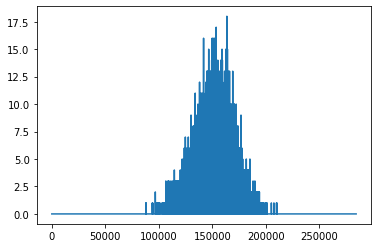

In [176]:
#datat="Expériences/data_terrain_petit.txt"
#datal="Expériences/data_legumes_petit.txt"
#data=Data(datal,datat)

#repartition(5000,data)